# CodeBERT
## Luis Arturo Rendon Inarritu
### A01703572 

### Imports

In [128]:
import torch
from torch import nn
from torch.optim import AdamW
from os.path import join as joinpath
import pandas as pd
import matplotlib.pyplot as plt
from transformers import(
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup)

from transformers.optimization import get_linear_schedule_with_warmup
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm, trange
import numpy as np

### Model name and dataset read

In [129]:
MODEL_NAME = "huggingface/CodeBERTa-small-v1"
plag_dataset = pd.read_csv(joinpath('..', 'plag_dataset.csv'))

In [130]:
print(f'Dataset lenght {len(plag_dataset)}')
plag_dataset.head()

Dataset lenght 1371


,Unnamed: 0,original,untrusted,plagiarism
0,0,public class T1 { public static void main(Str...,import java.util.Scanner; public class Soal1 ...,0
1,1,public class T1 { public static void main(Str...,public class Kasus1L1 { public stati...,1
2,2,public class T1 { public static void main(Str...,public class Kasus1L3 { public stati...,1
3,3,public class T1 { public static void main(Str...,public class Kasus1L6 { public ...,1
4,4,public class T1 { public static void main(Str...,public class L1 { public static void main...,1


### Divide dataset in train 80% and test 20%

In [131]:
train, test = train_test_split(plag_dataset, test_size=0.2, random_state=69)

In [132]:
print(f'Train size: {len(train)}\nTest size: {len(test)}')

Train size: 1096
Test size: 275


## Tokenization
This section is meant to show the tokenization process for the bert transformer

In [133]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

In [134]:
print(tokenizer)

RobertaTokenizerFast(name_or_path='huggingface/CodeBERTa-small-v1', vocab_size=52000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}
)


In [135]:
original_string = 'public static void main(String[] args){}'
print(f'Original string: {original_string}')

token_ids = tokenizer.encode(original_string)
print(f'Token IDs: {token_ids}')

tokens = tokenizer.convert_ids_to_tokens(token_ids)
print(f'Tokens: {tokens}')

Original string: public static void main(String[] args){}
Token IDs: [0, 479, 807, 954, 3923, 12, 570, 751, 1327, 46561, 2]
Tokens: ['<s>', 'public', 'Ġstatic', 'Ġvoid', 'Ġmain', '(', 'String', '[]', 'Ġargs', '){}', '</s>']


In [136]:
sourceCode = plag_dataset['original'].iloc[0]

token_ids = tokenizer.encode_plus(
  sourceCode,
  max_length = 512,
  padding = 'max_length',
  truncation = True,
  return_tensors = 'pt',
)

print('Token IDs:')
print(token_ids['input_ids'])

print('Attention Mask:')
print(token_ids['attention_mask'])


Token IDs:
tensor([[    0,  1291,  1299,   461,    21,   284,  1291,   807,   954,  3923,
            12,   570,   751,  1327,    13,   284,  2820,    18,   557,    18,
          3344,   427, 35248,   386,  7974,   748,  2820,    18,   557,    18,
          3344,   427, 35248,   386,  7974,   748,  2820,    18,   557,    18,
          3344,   427, 35248,   386,  7974,   748,  2820,    18,   557,    18,
          3344,   427, 35248,   386,  7974,   748,  2820,    18,   557,    18,
          3344,   427, 35248,   386,  7974,   748,   302,   302,   225,     2,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     

# Model definition

In [137]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data Loading

In [138]:
class TokenizedDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

        # just keep the texts and the label
        self.original  = df["original"].tolist()
        self.untrusted = df["untrusted"].tolist()
        self.labels    = df["plagiarism"].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "code_a": self.original[idx],
            "code_b": self.untrusted[idx],
            "label":  self.labels[idx],
        }

In [139]:
def collate_fn(batch, max_len=256):
    texts_a = [item['code_a'] for item in batch]
    texts_b = [item['code_b'] for item in batch]
    labels  = torch.tensor([item['label'] for item in batch])

    enc = tokenizer(
        texts_a,
        texts_b,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )
    enc['labels'] = labels
    return enc


In [140]:
class EmbeddedDataset(Dataset):
  def __init__(self, path):
    data = torch.load(path)
    self.originals = data['originals']
    self.untrusted = data['untrusted']
    self.labels = data['labels']

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return {
      'original': self.originals[idx],
      'untrusted': self.untrusted[idx],
      'label': self.labels[idx],
    }

In [141]:
train_dataset = TokenizedDataset(train)
test_dataset = TokenizedDataset(test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                          collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=16,
                          collate_fn=collate_fn)


# Training

### Choose device for training, NVIDIA, APPLE, or processor

In [142]:
def best_device() -> torch.device:
    """mps → cuda → cpu"""
    if torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

In [143]:
@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for batch in tqdm(dataloader, desc="Eval", leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss   = outputs.loss
        logits = outputs.logits
        labels = batch["labels"]

        total_loss   += loss.item() * labels.size(0)
        total_correct += (logits.argmax(-1) == labels).sum().item()
        total_samples += labels.size(0)

    return {
        "loss": total_loss / total_samples,
        "accuracy": total_correct / total_samples
    }

## Config and history (for saving data through trainig)

In [144]:
EPOCHS = 3
history = {k: [] for k in (
    "train_loss", "test_loss", "train_accuracy", "test_accuracy"
)}

optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * EPOCHS,
)

device = best_device()
print(f"Using device → {device}", flush=True)
model.to(device)

Using device → mps


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

## Training loop

In [145]:
for epoch in trange(EPOCHS, desc="Epochs"):
    model.train()

    prog = tqdm(
        enumerate(train_loader, 1),
        total=len(train_loader),
        desc=f"Train {epoch+1}/{EPOCHS}",
        leave=False,
    )

    for _, batch in prog:
        batch = {k: v.to(device) for k, v in batch.items()}
        loss  = model(**batch).loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        prog.set_postfix(loss=f"{loss.item():.4f}")

    # ─── end of epoch ──────────────────────────────────────────────
    train_metrics = evaluate(model, train_loader, device)
    test_metrics  = evaluate(model, test_loader,  device)

    history["train_loss"].append(train_metrics["loss"])
    history["train_accuracy"].append(train_metrics["accuracy"])
    history["test_loss"].append(test_metrics["loss"])
    history["test_accuracy"].append(test_metrics["accuracy"])

    print(
        f"Epoch {epoch+1:02d} | "
        f"train loss {train_metrics['loss']:.4f} – acc {train_metrics['accuracy']:.3f} | "
        f"test loss  {test_metrics['loss']:.4f} – acc {test_metrics['accuracy']:.3f}",
        flush=True,
    )


Epochs:   0%|          | 0/3 [06:48<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(**batch).logits  # shape [B,2]
        preds = logits.argmax(1)
        ...


# Plotting


In [ ]:
print(history)

{'train_loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'test_loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'train_accuracy': [0.5711678832116789, 0.5711678832116789, 0.5711678832116789, 0.5711678832116789, 0.5711678832116789, 0.5711678832116789, 0.5711678832116789, 0.5711678832116789, 0.5711678832116789, 0.5711678832116789, 0.5711678832116789, 0.5711678832116789, 0.5711678832116789, 0.5711678832116789, 0.5711678832116789], 'test_accuracy': [0.5054545454545455, 0.5054545454545455, 0.5054545454545455, 0.5054545454545455, 0.5054545454545455, 0.5054545454545455, 0.5054545454545455, 0.5054545454545455, 0.5054545454545455, 0.5054545454545455, 0.5054545454545455, 0.5054545454545455, 0.5054545454545455, 0.5054545454545455, 0.5054545454545455]}


In [ ]:
for k, v in history.items():
    if len(v) == 0:
        print(f"⚠️  'history[\"{k}\"]' is empty – did you run training first?")
        # you can 'break' here if you want to abort plotting
epochs = np.arange(1, len(history["train_loss"]) + 1)

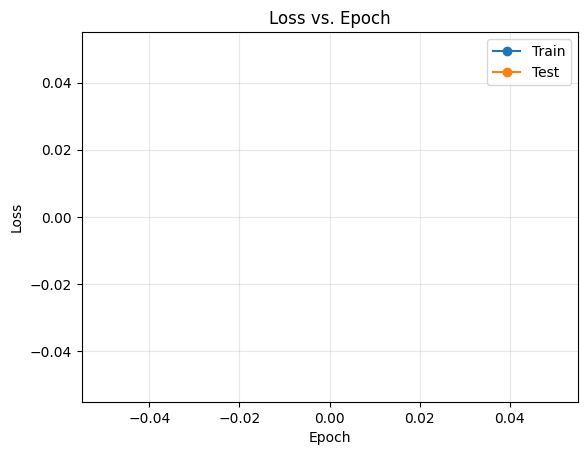

In [ ]:
# 1️⃣  Loss curve
plt.close("all")                              # clear stale figures
plt.figure()
plt.plot(epochs, history["train_loss"], "o-", label="Train")
plt.plot(epochs, history["test_loss"],  "o-", label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=.3)
plt.legend()
plt.show()

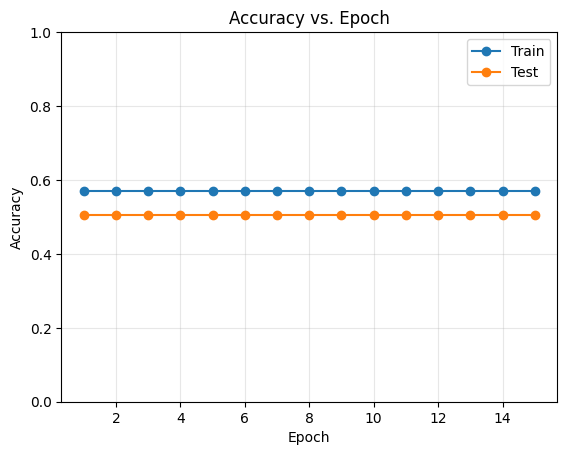

In [ ]:
# 2️⃣  Accuracy curve
plt.figure()
plt.plot(epochs, history["train_accuracy"], "o-", label="Train")
plt.plot(epochs, history["test_accuracy"],  "o-", label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=.3)
plt.legend()
plt.show()

In [ ]:
# 3️⃣  Confusion matrix & classification report
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        labels = batch["labels"].to(device)
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        logits = model(**inputs).logits
        preds  = logits.argmax(dim=-1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
labels = list(model.config.id2label.values())  # ["0", "1"] or custom names

# pretty print as a DataFrame
df_cm = pd.DataFrame(cm,
                     index=[f"True {l}" for l in labels],
                     columns=[f"Pred {l}" for l in labels])
display(df_cm.style.background_gradient(cmap="Blues").format("{:.0f}"))

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=labels))

,Pred LABEL_0,Pred LABEL_1
True LABEL_0,139,0
True LABEL_1,136,0



Classification report:
              precision    recall  f1-score   support

     LABEL_0       0.51      1.00      0.67       139
     LABEL_1       0.00      0.00      0.00       136

    accuracy                           0.51       275
   macro avg       0.25      0.50      0.34       275
weighted avg       0.26      0.51      0.34       275



/Users/arthur/zprogramming/codeBERT/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/arthur/zprogramming/codeBERT/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/arthur/zprogramming/codeBERT/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 